# 5.5 Poisson Regression

The purpose of this analysis is to understand how much the two explanatory 
variables of customers (Sex and Income) contribute to their counts of visits M.


Here we will use the same dataset we used in Sect. 5.3. 
- For instance, we are interested to know whether male customers are more likely to visit 
the website than the female customers. 
- Hence, instead of using Y , which is the counts of purchases, we will use counts of visits M as the response variable. As in this case, when we use data that is non-negative and discrete, and has no upper limit, using 
Poisson distribution is the first option.

In [23]:
import os, sys

cwd = os.getcwd()
if '\\' in cwd:
    cwd_parts = cwd.split('\\')
else:
    cwd_parts = cwd.split('/')
current_dir = cwd_parts[-1]
if current_dir != 'chap05':
    os.chdir('../../chap05')
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\chap05


In [24]:
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

d = pandas.read_csv('input/data-shopping-2.csv')
d.Income /= 100
d.drop(columns='PersonID', inplace=True)
d.drop(columns='Y', inplace=True)

data = d.to_dict('list')  # The time of visits M is modeled as a Poisson distribution
data.update({'N':len(d)})

d.tail()

,Sex,Income,M
45,0,0.716,6
46,0,0.489,6
47,0,0.793,9
48,0,0.534,5
49,1,0.700,12


## Check Data Distribution

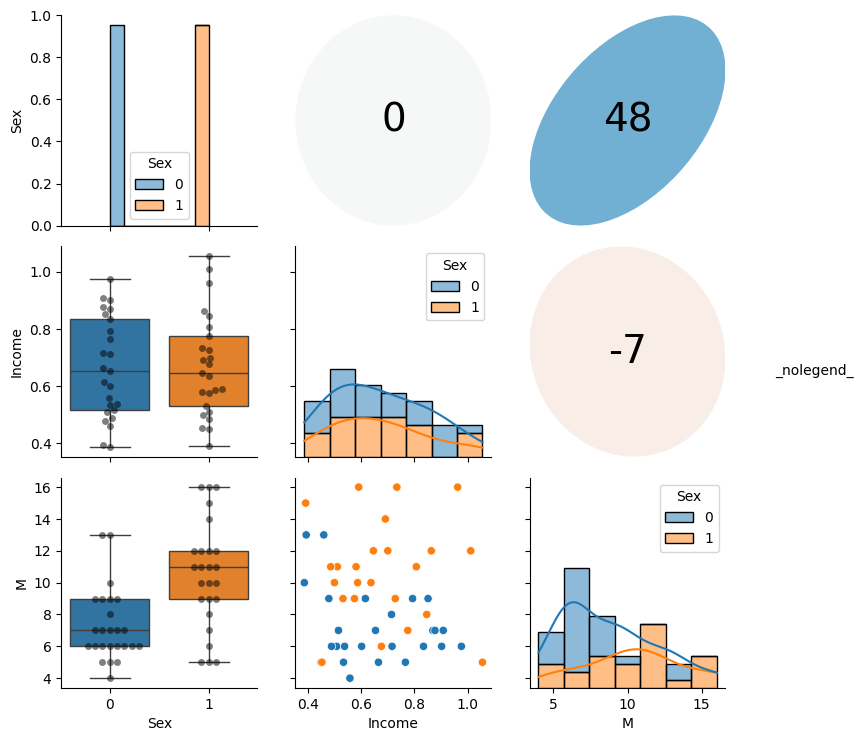

In [25]:
from scipy import stats
import math

def plot_lower(x, y, **kws):
    d_ = pandas.DataFrame({'x':x, 'y':y, 'Sex':d.Sex})
    if x.nunique() < 5:
        sns.boxplot(data=d_, x='x', y='y', hue='Sex')
        sns.swarmplot(data=d_, x='x', y='y', color='black', alpha=0.5)
    else:
        sns.scatterplot(data=d_, x='x', y='y', hue='Sex')

def plot_diag(x, **kws):    
    d_ = pandas.DataFrame({'x':x, 'Sex':d.Sex})
    sns.histplot(data=d_, x='x', hue='Sex', multiple='stack', kde=True)

def plot_upper(x, y, **kws):
    from matplotlib.patches import Ellipse
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('off')
    ellcolor = plt.cm.RdBu(0.5*(r+1))
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.add_artist(Ellipse(xy=[.5, .5], width=math.sqrt(1+r), height=math.sqrt(1-r), angle=45,
        facecolor=ellcolor, edgecolor='none', transform=ax.transAxes))
    ax.text(.5, .5, '{:.0f}'.format(r*100), color=txtcolor, fontsize=28,
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

g = sns.PairGrid(d)
g.map_lower(plot_lower)
g.map_diag(plot_diag)
g.map_upper(plot_upper)
g.add_legend()
plt.show()

## Data Generating Mechanism & Stan

In [26]:
import cmdstanpy
model = cmdstanpy.CmdStanModel(stan_file='model/model5-6.stan')

In [27]:
print(model.code())

data {
  int N;
  vector<lower=0, upper=1>[N] Sex;
  vector<lower=0>[N] Income;
  array[N] int<lower=0> M;
}

parameters {
  vector[3] b;
}

transformed parameters {
  vector[N] lam = exp(b[1] + b[2]*Sex[1:N] + b[3]*Income[1:N]);
}

model {
  M[1:N] ~ poisson(lam[1:N]);
}

generated quantities {
  array[N] int mp = poisson_rng(lam[1:N]);
}



### Model Formula 5.5

$$
\begin{align}
    \lambda[n]  & =  \exp (b_1 + b_2 Sex[n] + b_3 Income[n]), \quad\quad n=1,...,N \\
    Y[n]  & \sim  \mathrm{Poisson}(\lambda[n])
\end{align}
$$

In [28]:
# input data to Stan
data = {'N': len(d),  # N -> V
        'Sex': d['Sex'].tolist(),
        'Income': d['Income'].tolist(),
        'M': d['M'].tolist()}

In [29]:
# Suppress all output from model.sample() including logger messages
import warnings
import sys
from contextlib import redirect_stdout, redirect_stderr
import os
import logging

# Suppress cmdstanpy logger messages completely
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
# Or use CRITICAL to suppress even warnings: logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)

# Method 1: Use show_console=False (most effective)
fit = model.sample(data=data, seed=123, show_console=False, show_progress=False)

print("Sampling completed.")
fit.summary()

Sampling completed.


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,531.583000,0.031843,1.206360,0.990733,529.131000,531.889000,532.891000,1425.16,1936.00,2624.61,1.00205
b[1],2.096120,0.005417,0.192235,0.200304,1.781990,2.096610,2.402770,1265.26,1284.29,2330.13,1.00154
b[2],0.366921,0.002328,0.095422,0.095244,0.215154,0.365847,0.523802,1686.07,1565.95,3105.10,1.00369
b[3],-0.174292,0.007410,0.270104,0.280437,-0.613736,-0.167865,0.270991,1340.75,1379.50,2469.15,1.00169
lam[1],7.042490,0.013092,0.641946,0.633177,6.013780,7.022960,8.128260,2430.28,2347.05,4475.65,1.00193
...,...,...,...,...,...,...,...,...,...,...,...
mp[46],7.253000,0.044329,2.711240,2.965200,3.000000,7.000000,12.000000,3789.39,3855.30,6978.63,1.00004
mp[47],7.487500,0.044209,2.741210,2.965200,3.000000,7.000000,12.000000,3932.38,3694.36,7241.94,1.00020
mp[48],7.157750,0.046678,2.786450,2.965200,3.000000,7.000000,12.000000,3600.15,3506.73,6630.12,1.00131
mp[49],7.447750,0.045166,2.828120,2.965200,3.000000,7.000000,12.000000,3932.26,4012.77,7241.73,1.00035


In [30]:
# Also suppress messages from model.optimize()
mapest = model.optimize(data=data, seed=123, show_console=False)
print(mapest.b)

[ 2.106772    0.36567326 -0.183901  ]


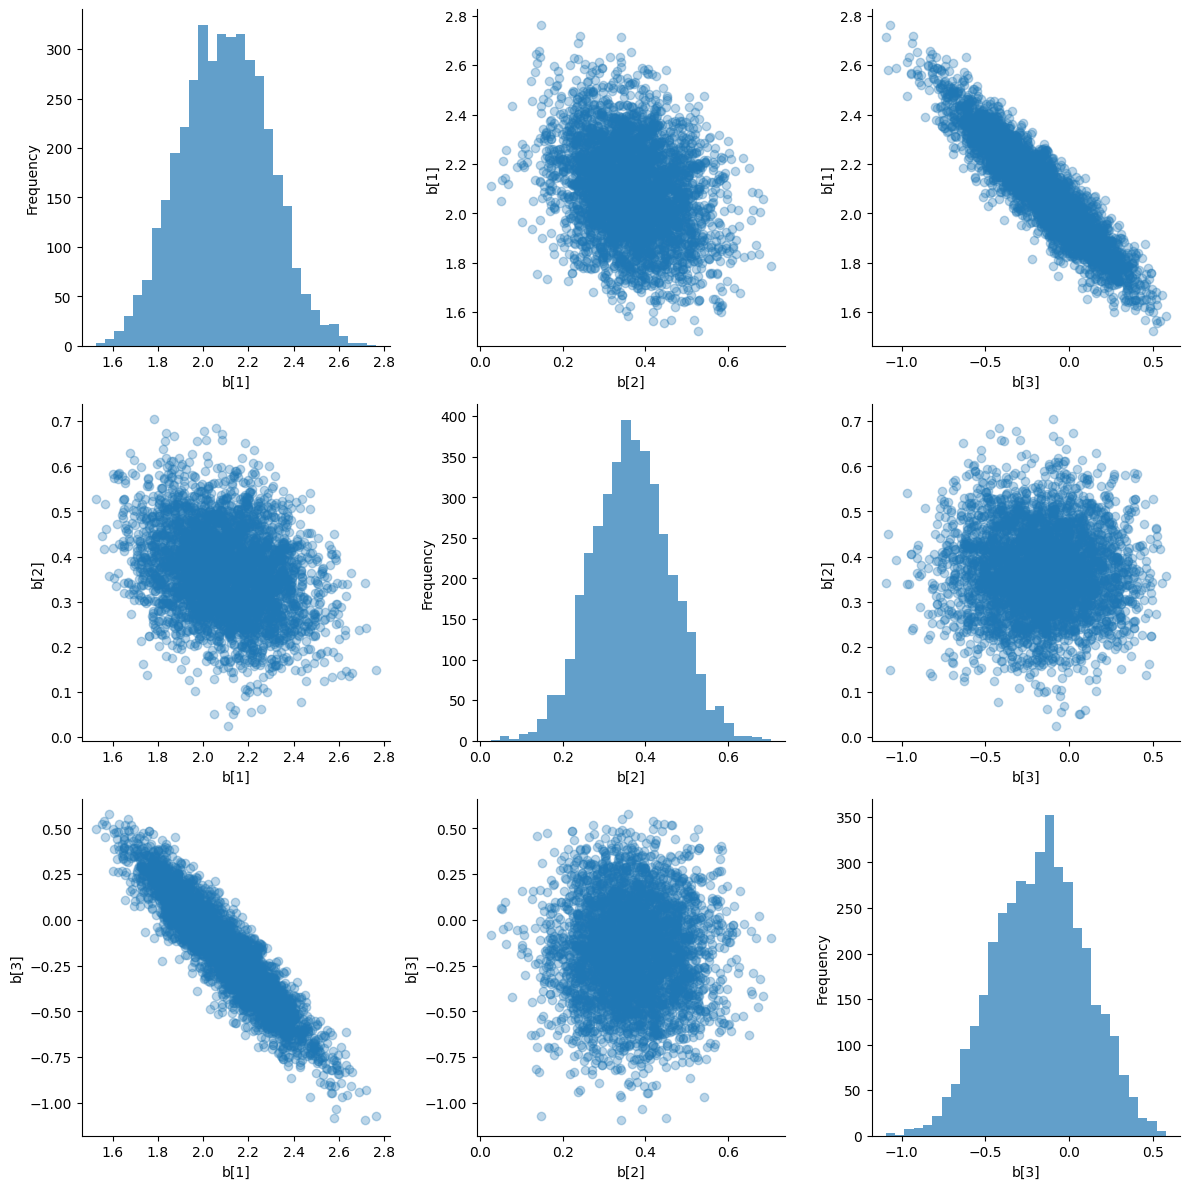

In [31]:
# Extract parameters b[1], b[2], b[3] from the fit
samples = fit.draws_pd()
b_params = samples[['b[1]', 'b[2]', 'b[3]']]

# Create 3x3 scatter plot matrix
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

param_names = ['b[1]', 'b[2]', 'b[3]']

for i in range(3):
    for j in range(3):
        if i == j:
            # Diagonal: histograms
            axes[i, j].hist(b_params[param_names[i]], bins=30, alpha=0.7)
            axes[i, j].set_xlabel(param_names[i])
            axes[i, j].set_ylabel('Frequency')
        else:
            # Off-diagonal: scatter plots
            axes[i, j].scatter(b_params[param_names[j]], b_params[param_names[i]], alpha=0.3)
            axes[i, j].set_xlabel(param_names[j])
            axes[i, j].set_ylabel(param_names[i])

plt.tight_layout()
plt.show()

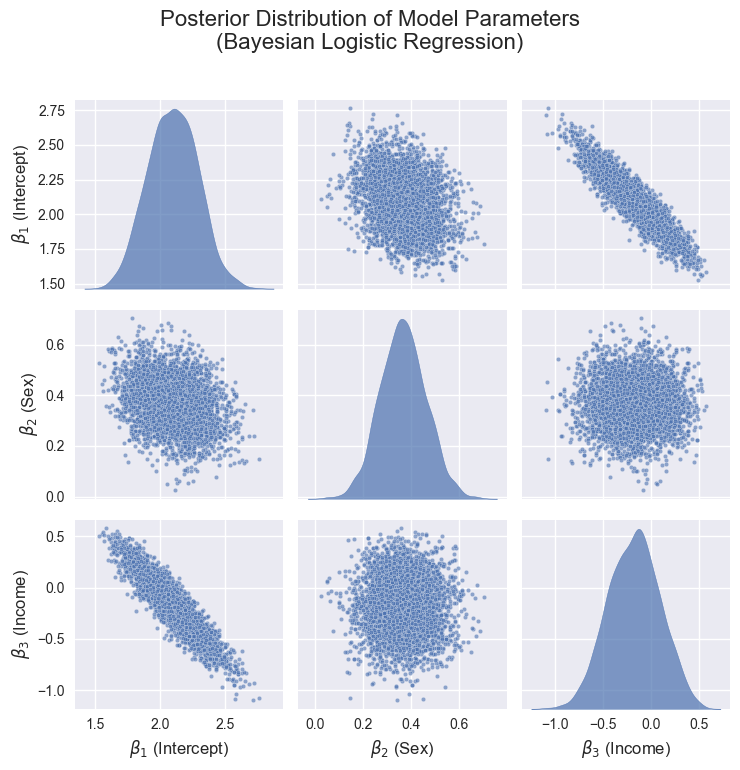

In [32]:
# Beautiful pairplot with enhanced styling
plt.style.use('seaborn-v0_8')  # Use seaborn style
g = sns.pairplot(data=b_params, 
                diag_kind='kde',  # Use KDE for diagonal instead of histogram
                plot_kws={'alpha': 0.6, 's': 10},  # More transparent points, smaller size
                diag_kws={'fill': True, 'alpha': 0.7})  # Shaded KDE

# Customize the figure
g.fig.suptitle('Posterior Distribution of Model Parameters\n(Bayesian Logistic Regression)', 
               fontsize=16, y=1.02)

# Add parameter labels with Greek letters
param_labels = [r'$\beta_1$ (Intercept)', r'$\beta_2$ (Sex)', r'$\beta_3$ (Income)']
for i, label in enumerate(param_labels):
    g.axes[i, 0].set_ylabel(label, fontsize=12)
    g.axes[-1, i].set_xlabel(label, fontsize=12)

plt.tight_layout()
plt.show()

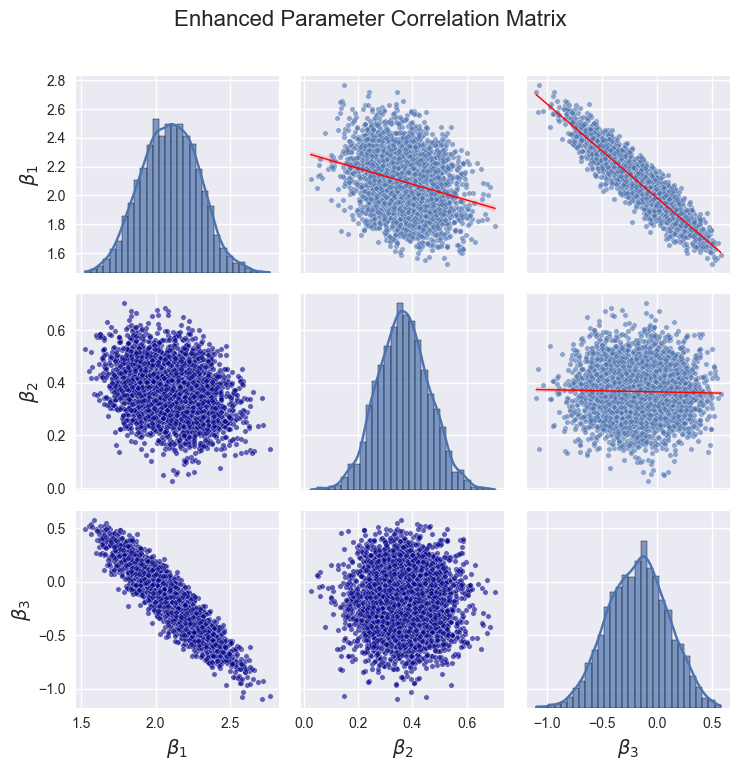

In [33]:
# Alternative 1: Custom PairGrid with more control
g = sns.PairGrid(b_params, height=2.5)

# Upper triangle: scatter plots with regression lines
g.map_upper(sns.scatterplot, alpha=0.6, s=15)
g.map_upper(sns.regplot, scatter=False, color='red', line_kws={'linewidth': 1})

# Lower triangle: scatter plots with different colors
g.map_lower(sns.scatterplot, alpha=0.6, s=15, color='darkblue')

# Diagonal: beautiful histograms with KDE overlay
g.map_diag(sns.histplot, kde=True, alpha=0.7, bins=30)

# Add titles and labels
g.fig.suptitle('Enhanced Parameter Correlation Matrix', fontsize=16, y=1.02)
param_labels = [r'$\beta_1$', r'$\beta_2$', r'$\beta_3$']
for i, label in enumerate(param_labels):
    g.axes[i, 0].set_ylabel(label, fontsize=14)
    g.axes[-1, i].set_xlabel(label, fontsize=14)

plt.tight_layout()
plt.show()

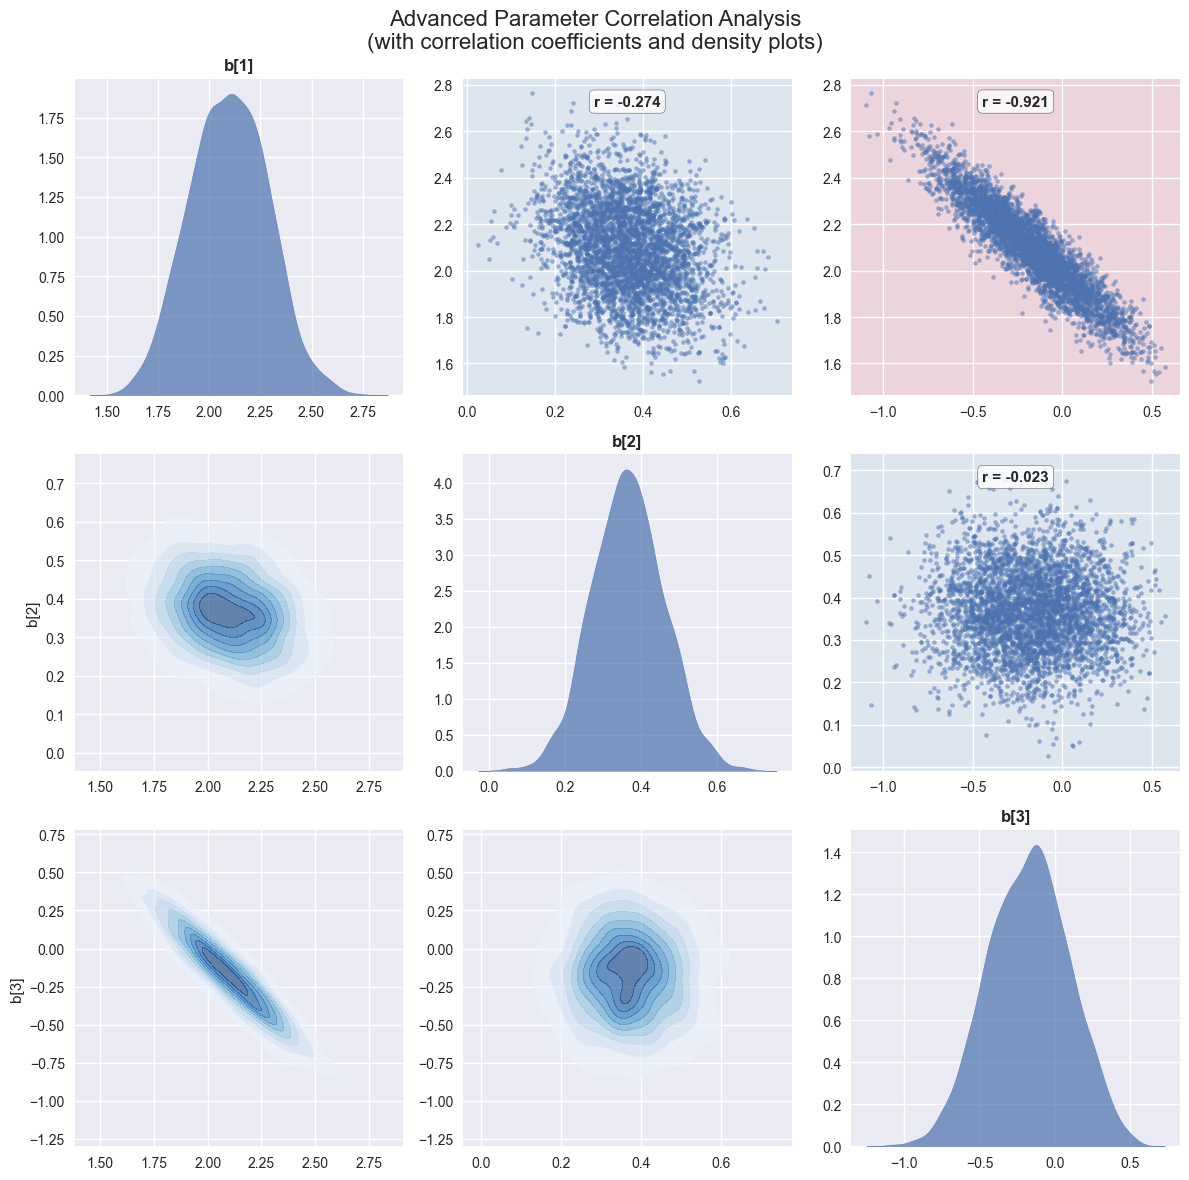

Parameter Correlation Matrix:
       b[1]   b[2]   b[3]
b[1]  1.000 -0.274 -0.921
b[2] -0.274  1.000 -0.023
b[3] -0.921 -0.023  1.000


In [34]:
# Alternative 2: Correlation matrix with correlation coefficients
from scipy import stats
import matplotlib.patches as patches

# Calculate correlation matrix
corr_matrix = b_params.corr()

# Create figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
param_names = b_params.columns

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: KDE plots with filled area
            sns.kdeplot(data=b_params, x=param_names[i], ax=ax, fill=True, alpha=0.7)
            ax.set_ylabel('')
            ax.set_title(f'{param_names[i]}', fontweight='bold')
            
        elif i < j:
            # Upper triangle: scatter with correlation coefficient
            x, y = b_params[param_names[j]], b_params[param_names[i]]
            correlation = corr_matrix.iloc[i, j]
            
            # Scatter plot
            ax.scatter(x, y, alpha=0.5, s=8)
            
            # Add correlation text
            ax.text(0.5, 0.95, f'r = {correlation:.3f}', 
                   transform=ax.transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=11, fontweight='bold')
            
            # Color background based on correlation strength
            if abs(correlation) > 0.7:
                color = 'lightcoral'
            elif abs(correlation) > 0.3:
                color = 'lightyellow'
            else:
                color = 'lightblue'
            ax.add_patch(patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                                         facecolor=color, alpha=0.2, zorder=0))
            
        else:
            # Lower triangle: 2D density plots
            sns.kdeplot(data=b_params, x=param_names[j], y=param_names[i], 
                       ax=ax, fill=True, alpha=0.6, cmap='Blues')
        
        # Clean up axes
        if i < 3:
            ax.set_xlabel('')
        if j > 0:
            ax.set_ylabel('')

plt.suptitle('Advanced Parameter Correlation Analysis\n(with correlation coefficients and density plots)', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Print correlation matrix
print("Parameter Correlation Matrix:")
print(corr_matrix.round(3))

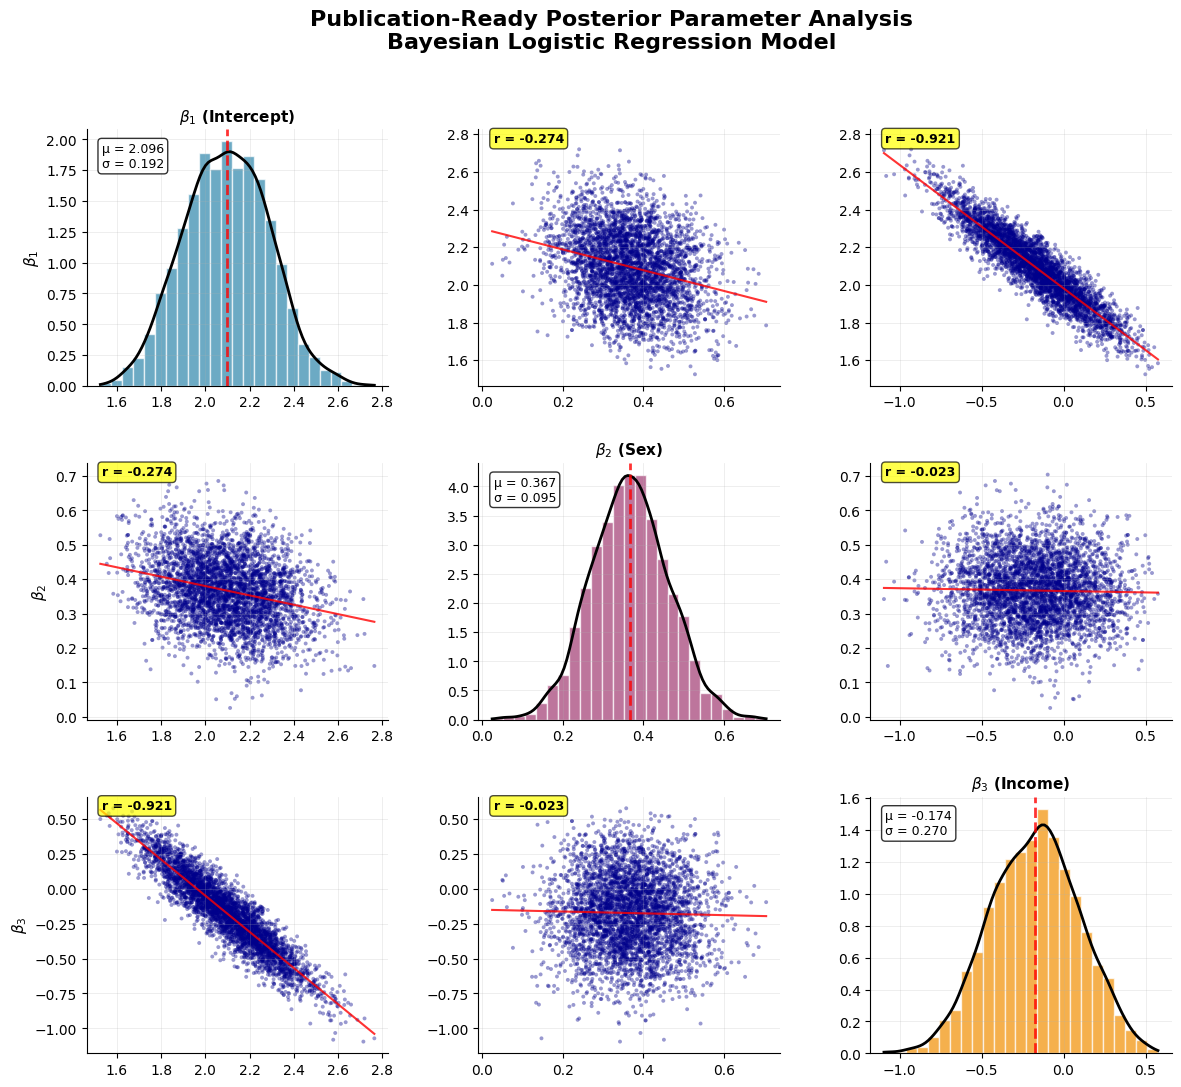

In [35]:
# Alternative 3: Professional publication-ready plot
import matplotlib.gridspec as gridspec

# Set up the plotting style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 10,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.bottom': True,
    'ytick.left': True,
})

# Create figure with custom layout
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(3, 3, hspace=0.3, wspace=0.3)

param_names = [r'$\beta_1$ (Intercept)', r'$\beta_2$ (Sex)', r'$\beta_3$ (Income)']
param_short = [r'$\beta_1$', r'$\beta_2$', r'$\beta_3$']
colors = ['#2E86AB', '#A23B72', '#F18F01']

for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(gs[i, j])
        
        if i == j:
            # Diagonal: enhanced histograms with statistics
            data_col = b_params.iloc[:, i]
            
            # Histogram with KDE overlay
            n, bins, patches = ax.hist(data_col, bins=25, alpha=0.7, 
                                     color=colors[i], density=True, edgecolor='white')
            
            # KDE overlay
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(data_col)
            x_range = np.linspace(data_col.min(), data_col.max(), 100)
            ax.plot(x_range, kde(x_range), color='black', linewidth=2)
            
            # Add statistics
            mean_val = data_col.mean()
            std_val = data_col.std()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, linewidth=2)
            
            # Statistics text
            stats_text = f'μ = {mean_val:.3f}\nσ = {std_val:.3f}'
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=9)
            
            ax.set_title(param_names[i], fontweight='bold', fontsize=11)
            
        else:
            # Off-diagonal: enhanced scatter plots
            x_data = b_params.iloc[:, j]
            y_data = b_params.iloc[:, i]
            
            # Create scatter plot with density coloring
            scatter = ax.scatter(x_data, y_data, c='darkblue', alpha=0.4, s=8, edgecolors='none')
            
            # Add regression line
            z = np.polyfit(x_data, y_data, 1)
            p = np.poly1d(z)
            ax.plot(x_data.sort_values(), p(x_data.sort_values()), 
                   color='red', linewidth=1.5, alpha=0.8)
            
            # Calculate and display correlation
            correlation = np.corrcoef(x_data, y_data)[0, 1]
            ax.text(0.05, 0.95, f'r = {correlation:.3f}', transform=ax.transAxes,
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                   fontsize=9, fontweight='bold')
        
        # Label formatting
        if i == 3:  # Bottom row
            ax.set_xlabel(param_short[j], fontsize=11, fontweight='bold')
        if j == 0:  # Left column
            ax.set_ylabel(param_short[i], fontsize=11, fontweight='bold')
        
        # Grid
        ax.grid(True, alpha=0.3, linewidth=0.5)

plt.suptitle('Publication-Ready Posterior Parameter Analysis\nBayesian Logistic Regression Model', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

## Personal Characteristic

In [48]:
d.tail()

,Sex,Income,M
45,0,0.716,6
46,0,0.489,6
47,0,0.793,9
48,0,0.534,5
49,1,0.700,12


In [42]:
d.M.value_counts()[:3]

M
6    9
9    7
7    6
Name: count, dtype: int64

In [43]:
b_params

,b[1],b[2],b[3]
0,1.938622,0.324281,0.101167
1,2.178277,0.295122,-0.183004
2,2.275341,0.303819,-0.305106
3,2.254349,0.296174,-0.343996
4,2.140347,0.343209,-0.202762
...,...,...,...
3995,2.027606,0.394985,-0.084507
3996,2.159319,0.303402,-0.173145
3997,2.250763,0.307840,-0.325815
3998,2.377750,0.336296,-0.541487


In [49]:
d.iloc[49]

Sex        1.0
Income     0.7
M         12.0
Name: 49, dtype: float64

1 0.7


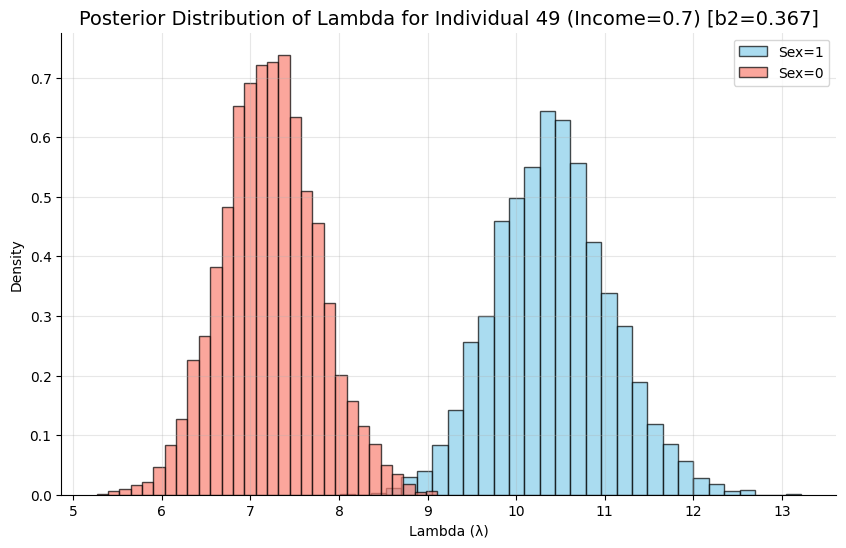

In [55]:
Sex = 1 #d.Sex[49]
Income = d.Income[49]
print(Sex, Income)
log_lam_1 = b_params['b[1]'] + b_params['b[2]'] * Sex + b_params['b[3]'] * Income
lam_1 = np.exp(log_lam_1)

Sex = 0
log_lam_0 = b_params['b[1]'] + b_params['b[2]'] * Sex + b_params['b[3]'] * Income
lam_0 = np.exp(log_lam_0)

plt.figure(figsize=(10, 6))
plt.hist(lam_1, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.hist(lam_0, bins=30, density=True, alpha=0.7, color='salmon', edgecolor='black')
plt.legend(['Sex=1', 'Sex=0'])
plt.xlabel('Lambda (λ)')
plt.ylabel('Density')
plt.title(f'Posterior Distribution of Lambda for Individual 49 (Income={Income}) [b2={b_params["b[2]"].mean():.3f}]', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [57]:
exp_b2 = np.exp(b_params['b[2]'].mean())
exp_b2

1.4432842963252632

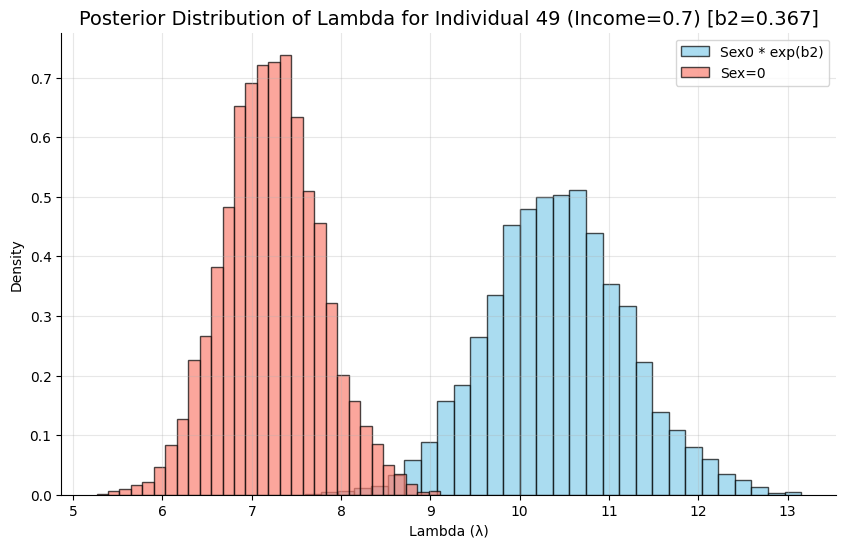

In [59]:
plt.figure(figsize=(10, 6))
plt.hist(lam_0 * exp_b2, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.hist(lam_0, bins=30, density=True, alpha=0.7, color='salmon', edgecolor='black')
plt.legend(['Sex0 * exp(b2)', 'Sex=0'])
plt.xlabel('Lambda (λ)')
plt.ylabel('Density')
plt.title(f'Posterior Distribution of Lambda for Individual 49 (Income={Income}) [b2={b_params["b[2]"].mean():.3f}]', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

끝.